In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm
import theano.tensor as T
import theano
theano.config.compute_test_value='ignore'

### Data Generation
Let's generate data with the following likelihood and see if our model can properly estimate model parameters with the data.<br>
Likelihood:
$$
p(y_i|\mathbf{x}_i, \mathbf{w}, \sigma) = \mathcal{N}\left(y_i| y(\mathbf{x}_i;\mathbf{w}), \sigma^2\right),
$$
where
$$
y(\mathbf{x}; \mathbf{w}) = w_{0} + w_{1}x_{1},\\w_0=-0.5,\\w_1=1.5,\\\sigma=0.85.
$$

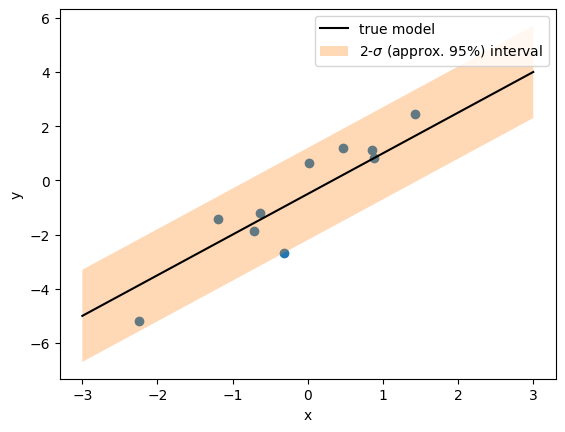

In [2]:
np.random.seed(1234) # for reproducibility

n = 10 # number of samples (datapoints)

w0 = -0.5
w1 = 1.5
sigma = 0.85

x = np.random.randn(n)  # input
y = w0 + w1*x + np.random.randn(n) * sigma

x_plot_true = np.linspace(-3,3,100) # points for visualization
y_plot_true = w0 + w1*x_plot_true # points for visualization

plt.scatter(x,y)
plt.plot(x_plot_true,y_plot_true,'k', label='true model')
plt.fill_between(x_plot_true, y_plot_true + 2*sigma, y_plot_true - 2*sigma, alpha=0.3, label='2-$\sigma$ (approx. 95%) interval')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Construct a model and infer model parameters
We assume that we do not know $w_0, w_1, \sigma$, and we don't have any prior knowledge.

In [3]:
t_x = T.constant(x)
t_y = T.constant(y)

# model construction
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # prior (very flat distributions)
    t_w0 = pm.Normal('w0', mu=0., sd=10.)
    t_w1 = pm.Normal('w1', mu=0., sd=10.)
    t_sigma = pm.Exponential('sigma', lam=1/100) # because standard deviation should be a positive value,
                                                 # we use exponential distribution instead.

    t_mu = t_w0 + t_w1*t_x

    # likelihood
    t_y_obs = pm.Normal('y_obs', mu=t_mu, sd=t_sigma, observed=t_y)

# inference
with model:
    trace = pm.sample(3000) # The default inference algorithm is NUTS sampling (https://arxiv.org/abs/1111.4246).
                            # This is much more efficient than Metropolis–Hastings

/Users/jinyoungko/anaconda3/envs/pymc3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w1, w0]


/Users/jinyoungko/anaconda3/envs/pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jinyoungko/anaconda3/envs/pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jinyoungko/anaconda3/envs/pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/jinyoungko/anaconda3/envs/pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.


### Visualize modelling results

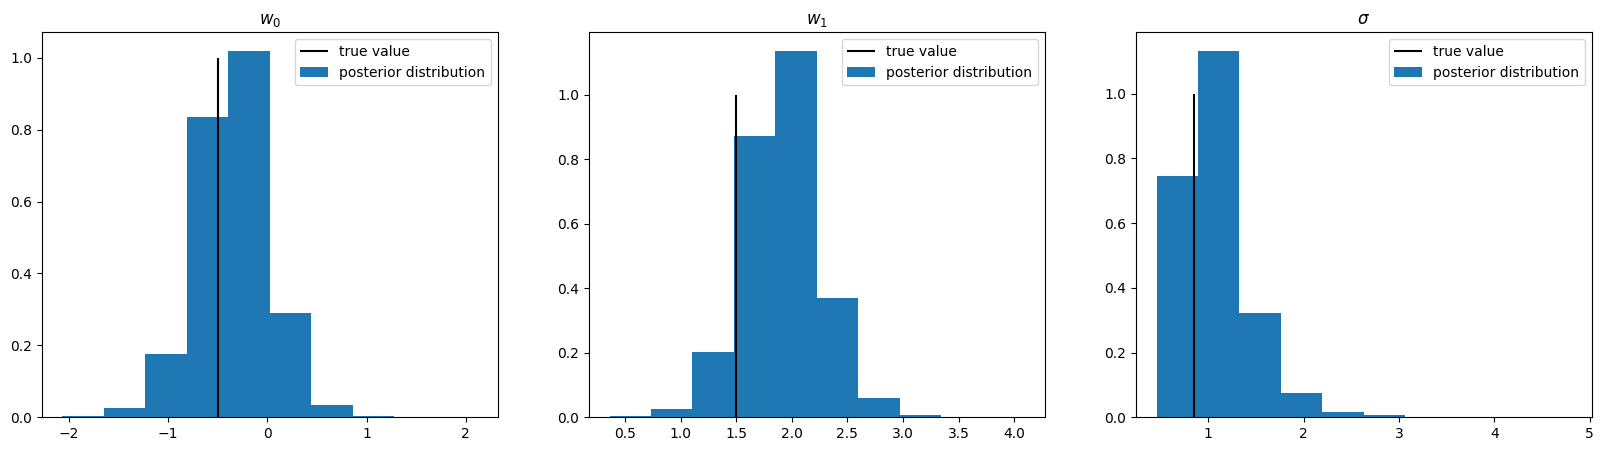

In [4]:
fig,ax = plt.subplots(1,3,figsize=(20,5))

ax[0].vlines(w0,0,1,color='k')
ax[0].hist(trace['w0'],density=True)
ax[0].set_title('$w_0$')
ax[0].legend(['true value', 'posterior distribution'])

ax[1].vlines(w1,0,1,color='k')
ax[1].hist(trace['w1'],density=True)
ax[1].set_title('$w_1$')
ax[1].legend(['true value', 'posterior distribution'])

ax[2].vlines(sigma,0,1,color='k')
ax[2].hist(trace['sigma'],density=True)
ax[2].set_title('$\sigma$')
ax[2].legend(['true value', 'posterior distribution'])

plt.show()

The true values (black lines) are within the marginal posterior distributions. 

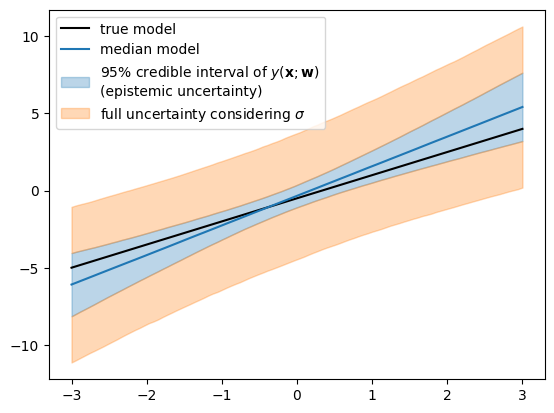

In [5]:
npost = trace['w0'].shape[0] # number of posterior samples

x_plot = np.linspace(-3,3,100) # points for visualization
y_plot = np.empty((npost, 3, 100)) # points for visualization

for i in range(npost):
    y_plot[i,0,:] = trace['w0'][i] + trace['w1'][i]*x_plot - 2*trace['sigma'][i]
    y_plot[i,1,:] = trace['w0'][i] + trace['w1'][i]*x_plot
    y_plot[i,2,:] = trace['w0'][i] + trace['w1'][i]*x_plot + 2*trace['sigma'][i]

    

y_plot_med = np.median(y_plot,axis=0)
y_plot_ub = np.percentile(y_plot,axis=0,q=97.5)
y_plot_lb = np.percentile(y_plot,axis=0,q=2.5)
plt.plot(x_plot_true, y_plot_true, 'k')
plt.plot(x_plot,y_plot_med[1,:])
plt.fill_between(x_plot, y_plot_lb[1,:], y_plot_ub[1,:],alpha=0.3, color='C0')
plt.fill_between(x_plot, y_plot_lb[0,:], y_plot_lb[1,:],alpha=0.3, color='C1')
plt.fill_between(x_plot, y_plot_ub[1,:], y_plot_ub[2,:],alpha=0.3, color='C1')
plt.legend(['true model',
            'median model',
            '95% credible interval of $y(\mathbf{x}; \mathbf{w})$\n(epistemic uncertainty)',
            'full uncertainty considering $\sigma$'])

### Questions:
+ 1. What if we have more/less data? How does the postrior distribution change?
+ 2. What if we assign a strong but wrong prior distribution instead of non-informative (flat) distribution?